In [1]:
# This code is based on Kayo Yin implementation that can be found at https://github.com/kayoyin/DirtyDocuments
# To properly use GPU processors, export the following env:
# export LD_LIBRARY_PATH=/usr/local/cuda-9.0/lib64:$LD_LIBRARY_PATH
# export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH

from __future__ import print_function, division
import scipy
import scipy.misc

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.metrics import mean_squared_error
import datetime
import sys
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
from keras.models import load_model
import tensorflow as tf

%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 30, 5

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.

    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.

    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.

    # Output shape
        Same shape as input.

    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Resources:
* [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
* [Keras Implementation of CycleGAN](https://github.com/eriklindernoren/Keras-GAN/tree/master/cyclegan)
* [Understanding and Implementing CycleGAN in TensorFlow](https://hardikbansal.github.io/CycleGANBlog/)
* [Image-to-image translation with Conditional Adversial Nets](https://phillipi.github.io/pix2pix/)
* [Conditional GAN](https://arxiv.org/pdf/1411.1784.pdf)

## Data sources:
### Dirty documents
* [Digitized Materials from the Rare Book & Special Collections Division](https://www.loc.gov/rr/rarebook/digitalcoll.html)

### Clean documents
* Anywhere online


In [4]:
class DataLoader():
    def __init__(self, img_res=(768, 512)):
        self.img_res = img_res
        self.img_height = img_res[0]
        self.img_width = img_res[1]

    def load_data(self, domain, batch_size=1, is_testing=False, is_random = True):
        data_type = "is_ocr_images" if not is_testing else "crappy_images"
        path = glob('../%s/*' % data_type)
        
        path_size = len(path)
        train_size = round(path_size * 0.7) - 1
        test_size = round(path_size * 0.2) + 1
        path = path[:train_size] if not is_testing else path[:test_size]
        
        len(path)

        if is_random: batch_images = np.random.choice(path, size=batch_size)
        else: batch_images = path
        
        imgs = []
        for img_path in batch_images:
            img = image.load_img(img_path, color_mode='grayscale', target_size=(self.img_height, self.img_width))
            img = image.img_to_array(img).astype('float32')
            img = img / 255.0
            if not is_testing and is_random:

                if np.random.random() > 0.5:
                    img = np.fliplr(img)

              
            imgs.append(img)

        imgs = np.array(imgs)

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_typeA = "is_ocr_images"
        data_typeB = "crappy_images"
        path_A = glob('../%s/*' % data_typeA)
        path_B = glob('../%s/*' % data_typeB)
        
        path_size = len(path_A)

        train_size = round(path_size * 0.7) - 1
        test_size = round(path_size * 0.2) + 1
        
        path_A = path_A[:train_size] if not is_testing else path_A[:test_size]
        path_B = path_B[:train_size] if not is_testing else path_B[:test_size]

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                try:
                    img_A = image.load_img(img_A, color_mode='grayscale', target_size=(self.img_height, self.img_width))
                    img_A = image.img_to_array(img_A).astype('float32')
                    img_A = img_A / 255.0

                    img_B = image.load_img(img_B, color_mode='grayscale', target_size=(self.img_height, self.img_width))
                    img_B = image.img_to_array(img_B).astype('float32')
                    img_B = img_B / 255.0

                    if not is_testing and np.random.random() > 0.5:
                            img_A = np.fliplr(img_A)
                            img_B = np.fliplr(img_B)

                    imgs_A.append(img_A)
                    imgs_B.append(img_B)
                except Exception as e:
                    print()

            imgs_A = np.array(imgs_A)
            imgs_B = np.array(imgs_B)

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img.resize(self.img_res)
        img = img/255.0
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return cv2.imread(path).astype(np.float)


In [5]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 768
        self.img_cols = 512
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.data_loader = DataLoader(img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch1 = int(self.img_rows / 2**4)
        patch2 = int(self.img_cols / 2**4)
        self.disc_patch = (patch1, patch2, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss (mainly to preserve color consistency)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)
        

        #img_A = img_A.reshape(1,256, 256,1)
        #img_B = img_B.reshape(1,256, 256,1)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)
        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
        
        print(Model(d0,output_img).summary())

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        g_losses = []
        d_losses = []

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                try:
                    # ----------------------
                    #  Train Discriminators
                    # ----------------------

                    # Translate images to opposite domain
                    imgs_A = imgs_A.reshape(-1,self.img_rows, self.img_cols,1)
                    imgs_B = imgs_B.reshape(-1,self.img_rows, self.img_cols,1)
                    fake_B = self.g_AB.predict(imgs_A)
                    fake_A = self.g_BA.predict(imgs_B)

                    # Train the discriminators (original images = real / translated = Fake)
                    dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                    dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                    dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                    dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                    # Total disciminator loss
                    d_loss = 0.5 * np.add(dA_loss, dB_loss)


                    # ------------------
                    #  Train Generators
                    # ------------------

                    # Train the generators
                    g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                            [valid, valid,
                                                            imgs_A, imgs_B,
                                                            imgs_A, imgs_B])

                    elapsed_time = datetime.datetime.now() - start_time

                    # Plot the progress
                    if batch_i % sample_interval == 0:
                        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                            % ( epoch+1, epochs,
                                                                                batch_i+1, self.data_loader.n_batches,
                                                                                d_loss[0], 100*d_loss[1],
                                                                                g_loss[0],
                                                                                np.mean(g_loss[1:3]),
                                                                                np.mean(g_loss[3:5]),
                                                                                np.mean(g_loss[5:6]),
                                                                                elapsed_time))
                
                    g_losses.append(g_loss[0])
                    d_losses.append(d_loss[0])
                except Exception as e:
                    print()

                # If at save interval => save generated image samples
                if (batch_i % 5000 == 0):
                    self.sample_images(epoch, batch_i)
                    #if epoch % (2*sample_interval) == 0:
                     #   self.d_A.save('d_A.h5')
                      #  self.d_B.save('d_B.h5')
                      #  self.g_AB.save('g_AB.h5')
                      #  self.g_BA.save('g_BA.h5')
                
        return d_losses, g_losses

    def sample_images(self, epoch, batch_i):
        os.makedirs('gan_images/', exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        imgs_A = imgs_A.reshape(-1,self.img_rows, self.img_cols,1)
        imgs_B = imgs_B.reshape(-1,self.img_rows, self.img_cols,1)

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        gen_imgs = np.concatenate([imgs_A[:,:,:,0], fake_B[:,:,:,0], reconstr_A[:,:,:,0], imgs_B[:,:,:,0], fake_A[:,:,:,0], reconstr_B[:,:,:,0]])

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt], cmap = 'gray')
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        
        fig.savefig("gan_images/%d_%d.png" % (epoch, batch_i), dpi = 800)
        plt.close()


In [6]:
gan = CycleGAN()
history = gan.train(epochs=1,batch_size=1,sample_interval=30)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 768, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 384, 256, 32) 544         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 384, 256, 32) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
instance_normalization_6 (Insta (None, 384, 256, 32) 2           leaky_re_lu_8[0][0]              
_______________________________________________________________________________________

In [11]:
TRAIN_IMAGES = glob('./trainA/*.jpg')
TEST_IMAGES = glob('./testA/*.jpg')

print(len(TRAIN_IMAGES))
print(len(TEST_IMAGES))

def load_images(path):
    img_height = 768
    img_width = 512
    image_list = np.zeros((len(path), img_height, img_width, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(img_height, img_width))
        x = image.img_to_array(img).astype('float32')
        image_list[i] = x
    
    return image_list

80
20


In [12]:
x_train = load_images(TRAIN_IMAGES)
x_test = load_images(TEST_IMAGES)

In [ ]:
x_train_gan = gan.g_AB.predict(x_train)
x_test_gan = gan.g_AB.predict(x_test)

In [ ]:
np.save('x_train_gan', x_train_gan)
np.save('x_test_gan', x_test_gan)

In [7]:
gan.d_A.save('original_d_A.h5')
gan.d_B.save('original_d_B.h5')
gan.g_AB.save('original_g_AB.h5')
gan.g_BA.save('original_g_BA.h5')

In [8]:
import pickle

In [41]:
modelin = load_model('original_g_BA.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

In [42]:
print(len(x_train))

80


In [43]:
new_img = modelin.predict(x_test[:12])
new_img.shape

(12, 768, 512, 1)

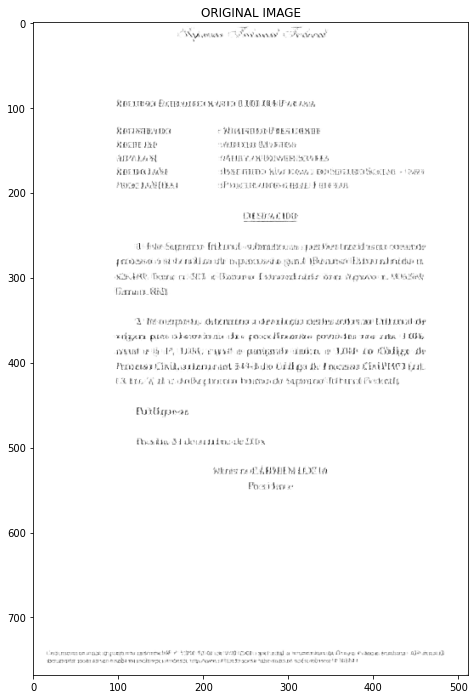

In [45]:
plt.figure(figsize=(16,12))
plt.imshow(new_img[0], cmap='gray')
plt.title('ORIGINAL IMAGE')
plt.show()